In [1]:
import os
import pandas as pd 
import numpy as np

In [2]:
data_dir = 'Data/CSV'
dataframes = []
for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    target = file_name[:-4] # remove ".csv"
    taget = target.split('_')[0] 

    df = pd.read_csv(file_path)
    #df.fillna(0, inplace=True)
    df['target'] = target
    dataframes.append(df)
    
    print(f"Number of {target}: " + str(df.shape[0]))

data = pd.concat(dataframes)
    

Number of bruteforce: 14501
Number of slowite: 9202
Number of flood: 613


/var/folders/yv/rl10xyh574v0pblkn8707bzr0000gn/T/ipykernel_69432/288588617.py:8: DtypeWarning: Columns (21,23,34,39,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of legitimate_1w: 11915716
Number of malformed: 10924


/var/folders/yv/rl10xyh574v0pblkn8707bzr0000gn/T/ipykernel_69432/288588617.py:8: DtypeWarning: Columns (21,23,34,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of malaria: 130223


# Distribution

<AxesSubplot: >

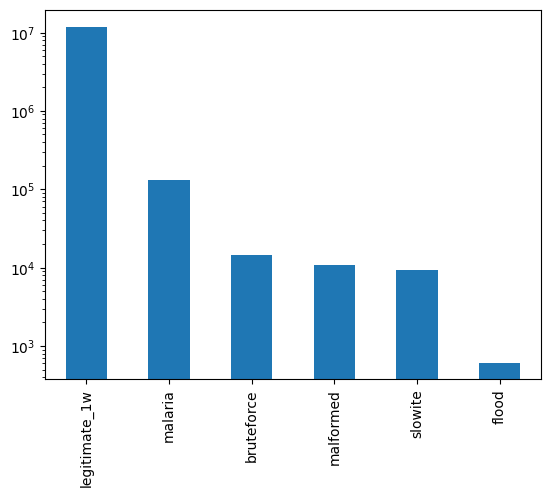

In [3]:
data['target'].value_counts().plot(kind='bar',logy=True)

In [4]:
print(data.dtypes.to_string())

frame.time_delta              float64
frame.time_delta_displayed    float64
frame.time_epoch              float64
frame.time_invalid            float64
frame.time_relative           float64
eth.src                        object
eth.dst                        object
ip.src                         object
ip.dst                         object
tcp.srcport                     int64
tcp.dstport                     int64
tcp.flags                      object
frame.cap_len                   int64
frame.len                       int64
frame.number                    int64
tcp.stream                      int64
tcp.analysis.initial_rtt      float64
tcp.time_delta                float64
tcp.len                         int64
tcp.window_size_value           int64
tcp.checksum                   object
mqtt.clientid                  object
mqtt.clientid_len             float64
mqtt.conack.flags              object
mqtt.conack.flags.reserved    float64
mqtt.conack.flags.sp          float64
mqtt.conack.

# Drop Useless Columns

In [5]:
data['ip.proto'].value_counts()

6    12081179
Name: ip.proto, dtype: int64

In [6]:
null_counts = data.isna().sum()
null_counts

frame.time_delta                     0
frame.time_delta_displayed           0
frame.time_epoch                     0
frame.time_invalid            12081179
frame.time_relative                  0
                                ...   
mqtt.willmsg_len              12081179
mqtt.willtopic                12081179
mqtt.willtopic_len            12081179
ip.proto                             0
target                               0
Length: 61, dtype: int64

In [7]:
# columns with >90% null values
cols_almost_all_nulls = [col for col, count in null_counts.iteritems() if count > 0.9 * data.shape[0]]
# columns with extreme distribution e.g. mostly zeors or null
cols_bad_dist = ['tcp.checksum','mqtt.msg', 'mqtt.topic', 'mqtt.username', 'mqtt.protoname',
            'mqtt.passwd', 'mqtt.conack.flags', 'mqtt.conflags', 'ip.proto']
# columns that are not useful
cols_not_informative = ['frame.time_epoch','eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'mqtt.passwd_len',
            'mqtt.username_len', 'mqtt.clientid', 'tcp.analysis.initial_rtt']

cols_to_drop = set(cols_almost_all_nulls + cols_bad_dist + cols_not_informative)
print(cols_to_drop)
data = data.drop(columns=cols_to_drop)

{'mqtt.msg', 'mqtt.conflag.retain', 'mqtt.willtopic_len', 'frame.time_epoch', 'mqtt.username_len', 'ip.src', 'mqtt.suback.qos', 'mqtt.passwd', 'mqtt.conflag.qos', 'tcp.analysis.initial_rtt', 'mqtt.willmsg_len', 'mqtt.sub.qos', 'mqtt.kalive', 'mqtt.clientid_len', 'mqtt.willtopic', 'mqtt.username', 'mqtt.clientid', 'eth.src', 'mqtt.conflag.uname', 'mqtt.willmsg', 'mqtt.conflags', 'mqtt.protoname', 'mqtt.msgid', 'mqtt.conflag.willflag', 'mqtt.topic', 'ip.proto', 'mqtt.conflag.reserved', 'tcp.checksum', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conack.flags.sp', 'ip.dst', 'mqtt.proto_len', 'mqtt.conack.val', 'frame.time_invalid', 'mqtt.conack.flags.reserved', 'mqtt.passwd_len', 'eth.dst', 'mqtt.conack.flags', 'mqtt.ver'}


# Impute Null Values

In [8]:
from sklearn.impute import SimpleImputer

numeric_cols = [col for col, dtype in data.dtypes.iteritems() if dtype in ['int', 'float']]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

sub_data = data[numeric_cols]
data[numeric_cols] = imp_mean.fit_transform(sub_data)

In [9]:
data['mqtt.hdrflags'].fillna('0', inplace=True)

In [10]:
data.isna().sum()

frame.time_delta              0
frame.time_delta_displayed    0
frame.time_relative           0
tcp.srcport                   0
tcp.dstport                   0
tcp.flags                     0
frame.cap_len                 0
frame.len                     0
frame.number                  0
tcp.stream                    0
tcp.time_delta                0
tcp.len                       0
tcp.window_size_value         0
mqtt.dupflag                  0
mqtt.hdrflags                 0
mqtt.len                      0
mqtt.msgtype                  0
mqtt.qos                      0
mqtt.retain                   0
mqtt.topic_len                0
target                        0
dtype: int64

# preprocess feature columns

In [11]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

features_to_encode = []
for col, dtype in data.dtypes.iteritems():
    # skip target 
    if col == 'target':
        continue
    # encode string features
    if str(dtype) == "object":
        print(col, dtype, data[col].unique().shape)
        # null was converted to 0, need to be converted to string for the encoder
        data[col] = data[col].astype(str)
        features_to_encode.append(col)

sub_data = data[features_to_encode]
enc.fit(sub_data)
print(enc.categories_)
data[features_to_encode] = enc.transform(sub_data)


tcp.flags object (8,)
mqtt.hdrflags object (14,)
[array(['0x00000002', '0x00000004', '0x00000010', '0x00000011',
       '0x00000012', '0x00000014', '0x00000018', '0x00000019'],
      dtype=object), array(['0', '0x00000010', '0x00000020', '0x00000030', '0x00000031',
       '0x00000032', '0x0000003a', '0x00000040', '0x00000050',
       '0x00000082', '0x00000090', '0x000000c0', '0x000000d0',
       '0x000000e0'], dtype=object)]


# Encode labels

In [12]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()

lenc.fit(data['target'])
print(lenc.classes_)
data['target'] = lenc.transform(data['target'])

['bruteforce' 'flood' 'legitimate_1w' 'malaria' 'malformed' 'slowite']


# Correlation Analysis

In [13]:
corr = data.corr()

In [14]:
corr.style.background_gradient(cmap='coolwarm')

,frame.time_delta,frame.time_delta_displayed,frame.time_relative,tcp.srcport,tcp.dstport,tcp.flags,frame.cap_len,frame.len,frame.number,tcp.stream,tcp.time_delta,tcp.len,tcp.window_size_value,mqtt.dupflag,mqtt.hdrflags,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,target
frame.time_delta,1.000000,1.000000,0.003488,0.075240,-0.174194,0.174048,0.013959,0.013959,0.003442,-0.004433,0.059175,0.013646,0.032270,-0.014044,0.119215,-0.071003,-0.034037,-0.024508,-0.001158,-0.149803,-0.026699
frame.time_delta_displayed,1.000000,1.000000,0.003488,0.075240,-0.174194,0.174048,0.013959,0.013959,0.003442,-0.004433,0.059175,0.013646,0.032270,-0.014044,0.119215,-0.071003,-0.034037,-0.024508,-0.001158,-0.149803,-0.026699
frame.time_relative,0.003488,0.003488,1.000000,-0.011740,-0.003867,0.006897,-0.040498,-0.040498,0.999998,-0.076491,0.003013,-0.042207,-0.075060,-0.066812,-0.017686,-0.107716,-0.000468,-0.114249,-0.005365,-0.110058,-0.130054
tcp.srcport,0.075240,0.075240,-0.011740,1.000000,-0.974225,-0.570605,0.010146,0.010146,-0.011632,0.017182,0.096187,0.010743,0.030861,0.072657,-0.449843,0.125006,0.010572,0.124237,-0.002694,0.120993,0.037109
tcp.dstport,-0.174194,-0.174194,-0.003867,-0.974225,1.000000,0.557221,0.003435,0.003435,-0.003856,0.018661,-0.099762,0.003509,0.000038,-0.046477,0.447061,-0.069856,-0.011965,-0.079472,0.004374,-0.039071,0.011293
tcp.flags,0.174048,0.174048,0.006897,-0.570605,0.557221,1.000000,0.019866,0.019866,0.006856,-0.031050,0.101306,0.019609,-0.040577,-0.039497,0.807279,-0.058952,0.000849,-0.060169,-0.002143,-0.057957,-0.016928
frame.cap_len,0.013959,0.013959,-0.040498,0.010146,0.003435,0.019866,1.000000,1.000000,-0.040141,-0.002792,-0.002572,0.999956,0.049771,0.183408,0.062954,0.296217,-0.013325,0.297472,0.011144,0.291885,0.095976
frame.len,0.013959,0.013959,-0.040498,0.010146,0.003435,0.019866,1.000000,1.000000,-0.040141,-0.002792,-0.002572,0.999956,0.049771,0.183408,0.062954,0.296217,-0.013325,0.297472,0.011144,0.291885,0.095976
frame.number,0.003442,0.003442,0.999998,-0.011632,-0.003856,0.006856,-0.040141,-0.040141,1.000000,-0.076622,0.002989,-0.041835,-0.074772,-0.065976,-0.017458,-0.106592,-0.000449,-0.113053,-0.005365,-0.108906,-0.128800
tcp.stream,-0.004433,-0.004433,-0.076491,0.017182,0.018661,-0.031050,-0.002792,-0.002792,-0.076622,1.000000,-0.010997,-0.000756,0.391419,0.001395,-0.039419,0.009127,-0.017087,0.001778,0.037678,0.004557,0.039244


In [15]:
cols_to_drop_corr = ['frame.time_delta_displayed', 'frame.time_relative', 'frame.cap_len', 'tcp.len',
            'tcp.dstport','mqtt.len', 'mqtt.topic_len']
data.drop(columns=cols_to_drop_corr, inplace=True)

# Cast feature types

In [16]:
features = data.drop(columns=['target'])
features = features.astype(np.float64)
labels   = data['target']

# Train/Test Split and Save to files

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [18]:
def save_file(df, file_name):
    save_dir = 'Data'
    df.to_csv(os.path.join(save_dir, file_name), index = False, header=True)

X_train['target'] = y_train
save_file(X_train, 'train.csv')

X_test['target'] = y_test
save_file(X_test, 'test.csv')

In [19]:
X_train.columns

Index(['frame.time_delta', 'tcp.srcport', 'tcp.flags', 'frame.len',
       'frame.number', 'tcp.stream', 'tcp.time_delta', 'tcp.window_size_value',
       'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.msgtype', 'mqtt.qos',
       'mqtt.retain', 'target'],
      dtype='object')